# Image classification training with image format

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Prepare the data](#Prepare-the-data)
3. [Fine-tuning The Image Classification Model](#Fine-tuning-the-Image-classification-model)
  1. [Training parameters](#Training-parameters)
  2. [Training](#Training)
4. [Deploy The Model](#Deploy-the-model)
  1. [Create model](#Create-model)
  2. [Batch transform](#Batch-transform)
  3. [Realtime inference](#Realtime-inference)
    1. [Create endpoint configuration](#Create-endpoint-configuration) 
    2. [Create endpoint](#Create-endpoint) 
    3. [Perform inference](#Perform-inference) 
    4. [Clean up](#Clean-up)

## Introduction

Welcome to our end-to-end example of the image classification algorithm training with image format. In this demo, we will use the Amazon sagemaker image classification algorithm in transfer learning mode to fine-tune a pre-trained model (trained on imagenet data) to learn to classify a new dataset. In particular, the pre-trained model will be fine-tuned using [caltech-256 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech256/). 

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [2]:
%%time
import boto3
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

CPU times: user 121 ms, sys: 12 ms, total: 133 ms
Wall time: 863 ms


# Aggregate and Clean Labeled Data into Training and Validation

Move data resize it and upload it to the correct folders

In [43]:
import os


bucket_name ='hywz.wastezero'
labels = ['compost','recycle']

s3 = boto3.resource('s3', region_name='us-west-1')
bucket = s3.Bucket(bucket_name)

compost_imgs = list(bucket.objects.filter(Prefix="compost"))
recycle_imgs = list(bucket.objects.filter(Prefix="recycle"))

count = 0


## Download all the images to local storage

In [36]:
help(bucket.objects.filter)

Help on method filter in module boto3.resources.collection:

filter(**kwargs) method of boto3.resources.collection.s3.Bucket.objectsCollectionManager instance
    Creates an iterable of all ObjectSummary resources in the collection filtered by kwargs passed to method.
    
    See also: `AWS API Documentation <https://docs.aws.amazon.com/goto/WebAPI/s3-2006-03-01/ListObjects>`_
    
    
    **Request Syntax** 
    ::
    
      object_summary_iterator = bucket.objects.filter(
          Delimiter='string',
          EncodingType='url',
          Marker='string',
          MaxKeys=123,
          Prefix='string',
          RequestPayer='requester'
      )
    :type Delimiter: string
    :param Delimiter: 
    
      A delimiter is a character you use to group keys.
    
      
    
    
    :type EncodingType: string
    :param EncodingType: 
    
      Requests Amazon S3 to encode the object keys in the response and specifies the encoding method to use. An object key may contain any Uni

In [41]:
for rimg, cimg in zip(recycle_imgs, compost_imgs):
    print(rimg)
    print(cimg)
    if rimg.key.endswith("jpg"):
        rfp = "{}/{}_{}.jpg".format(os.getcwd(), 'recycle', count)
        cfp = "{}/{}_{}.jpg".format(os.getcwd(), 'compost', count)

        bucket.download_file(rimg.key, rfp)
        bucket.download_file(cimg.key, cfp)

        count += 1


s3.ObjectSummary(bucket_name='hywz.wastezero', key='recycle/')
s3.ObjectSummary(bucket_name='hywz.wastezero', key='recycle//2018-10-20-17-45-15.jpg')
s3.ObjectSummary(bucket_name='hywz.wastezero', key='recycle//2018-10-20-17-51-55.jpg')
s3.ObjectSummary(bucket_name='hywz.wastezero', key='recycle//2018-10-20-18-18-15.jpg')
s3.ObjectSummary(bucket_name='hywz.wastezero', key='recycle//2018-10-20-18-34-45.jpg')
s3.ObjectSummary(bucket_name='hywz.wastezero', key='recycle//2018-10-20-20-30-36.jpg')
s3.ObjectSummary(bucket_name='hywz.wastezero', key='recycle//2018-10-20-20-32-28.jpg')
s3.ObjectSummary(bucket_name='hywz.wastezero', key='recycle//2018-10-20-20-33-23.jpg')
s3.ObjectSummary(bucket_name='hywz.wastezero', key='recycle//2018-10-28-20-23-04.jpg')
s3.ObjectSummary(bucket_name='hywz.wastezero', key='recycle//2018-10-28-20-23-31.jpg')
s3.ObjectSummary(bucket_name='hywz.wastezero', key='recycle//2018-10-28-20-23-50.jpg')
s3.ObjectSummary(bucket_name='hywz.wastezero', key='recycle//2018-1

## Resize All the Images

### Get the smallest image size in the bucket

In [50]:
%%time
from skimage.transform import resize
from skimage.io import imread, imsave
import glob

files = glob.glob("*.jpg")
imgs = []
x, y = [], []
for file in files:
    img = imread(file)
    shape = img.shape
    x.append(shape[0])
    y.append(shape[1])
    imgs.append((img, file))

CPU times: user 37.3 s, sys: 4.61 s, total: 41.9 s
Wall time: 41.9 s


In [58]:
scale = 4
x_min, y_min = min(x), min(y)
training_shape = (x_min / scale, y_min / scale, 3)

### Now Apply Sizing and Save Each Image

In [59]:
%%time
for img in imgs:
    nimg = resize(img[0], training_shape)
    print("Saving", img[-1])
    imsave(img[-1], nimg)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Saving compost_17.jpg


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Saving compost_35.jpg
Saving recycle_27.jpg
Saving compost_4.jpg
Saving compost_3.jpg
Saving compost_6.jpg
Saving compost_31.jpg
Saving compost_27.jpg
Saving compost_20.jpg
Saving recycle_32.jpg
Saving compost_7.jpg
Saving recycle_20.jpg
Saving recycle_12.jpg
Saving compost_24.jpg
Saving compost_34.jpg
Saving recycle_31.jpg
Saving compost_36.jpg
Saving recycle_15.jpg
Saving compost_19.jpg
Saving compost_23.jpg
Saving compost_5.jpg
Saving recycle_10.jpg
Saving compost_33.jpg
Saving recycle_21.jpg
Saving recycle_23.jpg
Saving recycle_33.jpg
Saving compost_29.jpg
Saving recycle_1.jpg
Saving recycle_8.jpg
Saving recycle_19.jpg
Saving recycle_26.jpg
Saving recycle_14.jpg
Saving recycle_30.jpg
Saving recycle_2.jpg
Saving recycle_29.jpg
Saving compost_12.jpg
Saving recycle_5.jpg
Saving recycle_11.jpg
Saving recycle_0.jpg
Saving compost_9.jpg
Saving compost_11.jpg
Saving compost_16.jpg
Saving compost_28.jpg
Saving recycle_24.jpg
Saving compost_25.jpg
Saving recycle_17.jpg
Saving recycle_9.jpg


## Visualize Results

In [60]:
from matplotlib import pyplot as plt
fp = imgs[0][-1]
print(fp)

compost_17.jpg


### Before

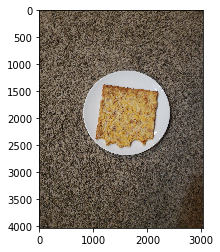

In [61]:
plt.imshow(imgs[0][0])

### After

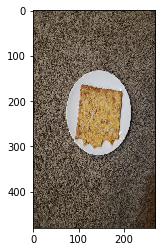

In [62]:
timg = imread(fp)

plt.imshow(timg)

# ReUpload images to their Final Destinations

## Perform Train/Test Split

In [75]:
tfolder = "train"
vfolder = "validation"
mod = 3 #this will be the ratio of training data to validation data 1/<mod>
sms3 = boto3.resource('s3', region_name='us-west-2')
smbucket_name = 'hywz.sagemaker'
smbucket = sms3.Bucket(smbucket_name)

In [74]:
%%time

training_paths = []

for i, file in zip(range(len(files)), files):
    folder_name = tfolder if i%mod != 0 else vfolder
    
    key = '{}/{}'.format(folder_name, file)
    smbucket.upload_file(file, key)
    print('Uploading', file,'as', key)
     
        

Uploading compost_17.jpg as validation/compost_17.jpg
Uploading compost_35.jpg as train/compost_35.jpg
Uploading recycle_27.jpg as train/recycle_27.jpg
Uploading compost_4.jpg as validation/compost_4.jpg
Uploading compost_3.jpg as train/compost_3.jpg
Uploading compost_6.jpg as train/compost_6.jpg
Uploading compost_31.jpg as validation/compost_31.jpg
Uploading compost_27.jpg as train/compost_27.jpg
Uploading compost_20.jpg as train/compost_20.jpg
Uploading recycle_32.jpg as validation/recycle_32.jpg
Uploading compost_7.jpg as train/compost_7.jpg
Uploading recycle_20.jpg as train/recycle_20.jpg
Uploading recycle_12.jpg as validation/recycle_12.jpg
Uploading compost_24.jpg as train/compost_24.jpg
Uploading compost_34.jpg as train/compost_34.jpg
Uploading recycle_31.jpg as validation/recycle_31.jpg
Uploading compost_36.jpg as train/compost_36.jpg
Uploading recycle_15.jpg as train/recycle_15.jpg
Uploading compost_19.jpg as validation/compost_19.jpg
Uploading compost_23.jpg as train/compost_

## Create LST File

In [118]:
path_to_s3 = 's3://{}/'.format(smbucket_name) #bucket name, folder, file

idict = {'compost': 0, 'recycle': 1}

v_files = list(smbucket.objects.filter(Prefix=vfolder))[1:]
t_files = list(smbucket.objects.filter(Prefix=tfolder))[1:]    

print(v_files[0:3])
print(t_files[0:3])

tlst_str, vlst_str = "", ""

[s3.ObjectSummary(bucket_name='hywz.sagemaker', key='validation/compost_0.jpg'), s3.ObjectSummary(bucket_name='hywz.sagemaker', key='validation/compost_1.jpg'), s3.ObjectSummary(bucket_name='hywz.sagemaker', key='validation/compost_17.jpg')]
[s3.ObjectSummary(bucket_name='hywz.sagemaker', key='train/compost_10.jpg'), s3.ObjectSummary(bucket_name='hywz.sagemaker', key='train/compost_11.jpg'), s3.ObjectSummary(bucket_name='hywz.sagemaker', key='train/compost_12.jpg')]


In [94]:
print(path_to_s3)

s3://hywz.sagemaker/


In [115]:
def create_lst(files, fp):
    idict = {'compost': 0, 'recycle': 1}
    frange = range(len(files))
    lst = ""
    for i, f in zip(frange, files):        
        if(f.key.endswith(".jpg")):
            label = idict[f.key.split('/')[-1].split("_")[0]]
            tfp = "{}/{}".format(fp, f.key)
            lst += "{}\t{}\t{}\n".format(i, int(label), f.key)            
        
    return lst
        

In [119]:
tlst_str = create_lst(t_files, path_to_s3)
vlst_str = create_lst(v_files, path_to_s3)

In [120]:
with open("train.lst", 'w') as tlst:
    tlst.write(tlst_str)
    
with open("validation.lst", "w") as vlst:
    vlst.write(vlst_str)
    
smbucket.upload_file("validation.lst", "validation_lst/validation.lst")
smbucket.upload_file("train.lst", "train/train.lst")

## Fine-tuning the Image Classification Model

### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Input specification**: These are the training and validation channels that specify the path where training data is present. These are specified in the "InputDataConfig" section. The main parameters that need to be set is the "ContentType" which can be set to "application/x-recordio" or "application/x-image" based on the input data format and the S3Uri which specifies the bucket and the folder where the data is present. 
* **Output specification**: This is specified in the "OutputDataConfig" section. We just need to specify the path where the output can be stored after training
* **Resource config**: This section specifies the type of instance on which to run the training and the number of hosts used for training. If "InstanceCount" is more than 1, then training can be run in a distributed manner. 

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
* **num_training_samples**: This is the total number of training samples. It is set to 15240 for caltech dataset with the current split.
* **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For caltech, we use 257 because it has 256 object categories + 1 clutter class.
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.
* **epochs**: Number of training epochs.
* **learning_rate**: Learning rate for training.
* **top_k**: Report the top-k accuracy during training.
* **resize**: Resize the image before using it for training. The images are resized so that the shortest side is of this parameter. If the parameter is not set, then the training data is used as such without resizing.
* **checkpoint_frequency**: Period to store model parameters (in number of epochs).
* **use_pretrained_model**: Set to 1 to use pretrained model for transfer learning.

In [121]:
len(t_files)

51

In [123]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = 18
# we need to specify the input image shape for the training data
image_shape = "{},{},{}".format(training_shape[-1], training_shape[0], training_shape[1])
# we also need to specify the number of training samples in the training set
num_training_samples = len(t_files)
# specify the number of output classes
num_classes = 2
# batch size for training
mini_batch_size = 10
# number of epochs
epochs = 6
# learning rate
learning_rate = 0.01
# report top_5 accuracy
top_k = 5
# resize image before training
resize = 500
# period to store model parameters (in number of epochs), in this case, we will save parameters from epoch 2, 4, and 6
checkpoint_frequency = 2
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 0

### Training
Run the training using Amazon sagemaker CreateTrainingJob API

In [124]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'custom-sagemaker-imageclassification'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "top_k": str(top_k),
        "resize": str(resize),
        "checkpoint_frequency": str(checkpoint_frequency),
        "use_pretrained_model": str(use_pretrained_model)    
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3train,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3validation,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "train_lst",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3train_lst,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation_lst",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3validation_lst,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

NameError: name 's3train' is not defined

In [ ]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

In [ ]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)
print (training_info)

If you see the message,

> `Training job ended with status: Completed`

then that means training sucessfully completed and the output model was stored in the output path specified by `training_params['OutputDataConfig']`.

You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab.

## Deploy The Model

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the class label given an input image.

This section involves several steps,

1. [Create model](#CreateModel) - Create model for the training output
1. [Batch Transform](#BatchTransform) - Create a transform job to perform batch inference.
1. [Host the model for realtime inference](#HostTheModel) - Create an inference endpoint and perform realtime inference.

### Create model

We now create a SageMaker Model from the training output. Using the model we can create an Endpoint Configuration.

In [ ]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name="image-classification-model" + timestamp
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

### Batch transform

We now create a SageMaker Batch Transform job using the model created above to perform batch prediction.

In [ ]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
batch_job_name="image-classification-model" + timestamp
batch_input = s3validation + "001.ak47/"
request = \
{
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 16,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "SingleRecord",
    "TransformOutput": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, batch_job_name)
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": batch_input
            }
        },
        "ContentType": "application/x-image",
        "SplitType": "None",
        "CompressionType": "None"
    },
    "TransformResources": {
            "InstanceType": "ml.p2.xlarge",
            "InstanceCount": 1
    }
}

print('Transform job name: {}'.format(batch_job_name))
print('\nInput Data Location: {}'.format(batch_input))

In [ ]:
sagemaker = boto3.client('sagemaker')
sagemaker.create_transform_job(**request)

print("Created Transform job with name: ", batch_job_name)

while(True):
    response = sagemaker.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    time.sleep(30)  

After the job completes, let's check the prediction results.

In [ ]:
from urllib.parse import urlparse
import json
import numpy as np

s3_client = boto3.client('s3')
object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']

def list_objects(s3_client, bucket, prefix):
    response = s3_client.list_objects(Bucket=bucket, Prefix=prefix)
    objects = [content['Key'] for content in response['Contents']]
    return objects

def get_label(s3_client, bucket, prefix):
    filename = prefix.split('/')[-1]
    s3_client.download_file(bucket, prefix, filename)
    with open(filename) as f:
        data = json.load(f)
        index = np.argmax(data['prediction'])
        probability = data['prediction'][index]
    print("Result: label - " + object_categories[index] + ", probability - " + str(probability))
    return object_categories[index], probability

inputs = list_objects(s3_client, bucket, urlparse(batch_input).path.lstrip('/'))
print("Sample inputs: " + str(inputs[:2]))

outputs = list_objects(s3_client, bucket, batch_job_name + "/output")
print("Sample output: " + str(outputs[:2]))

# Check prediction result of the first 2 images
[get_label(s3_client, bucket, prefix) for prefix in outputs[0:2]]

### Realtime inference

We now host the model with an endpoint and perform realtime inference.

This section involves several steps,
1. [Create endpoint configuration](#CreateEndpointConfiguration) - Create a configuration defining an endpoint.
1. [Create endpoint](#CreateEndpoint) - Use the configuration to create an inference endpoint.
1. [Perform inference](#PerformInference) - Perform inference on some input data using the endpoint.
1. [Clean up](#CleanUp) - Delete the endpoint and model

#### Create endpoint configuration
At launch, we will support configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [ ]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.p2.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

#### Create endpoint
Next, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [ ]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Finally, now the endpoint can be created. It may take sometime to create the endpoint...

In [ ]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))
    
try:
    sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sagemaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')

If you see the message,

> `Endpoint creation ended with EndpointStatus = InService`

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.

We will finally create a runtime object from which we can invoke the endpoint.

#### Perform inference
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [ ]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

##### Download test image

In [ ]:
!wget -O /tmp/test.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

In [ ]:
import json
import numpy as np
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

#### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released. Uncomment and run the following cell to delete the endpoint and model

In [ ]:
sage.delete_endpoint(EndpointName=endpoint_name)